## Clone Repository

In [1]:
# clone repository
!git clone https://github.com/ndoll1998/Pointnet4Berries.git P4B

Cloning into 'P4B'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 227 (delta 137), reused 188 (delta 100), pack-reused 0
Receiving objects: 100% (227/227), 78.78 KiB | 3.42 MiB/s, done.
Resolving deltas: 100% (137/137), done.


## Imports

In [2]:
# imports
import sys
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
# import model and utils
from P4B.Pointnet.models import Model_CLS
from P4B.utils.data import build_data_cls, cls_file_features
from P4B.utils.utils import compute_fscores
from P4B.utils.torchBoard import TorchBoard, ConfusionMatrix
from P4B.utils.augmentation import Augmenter, augment_mirror_pointcloud, augment_rotate_pointcloud
# import others
import os
import json
from time import time
from tqdm import tqdm_notebook as tqdm
from random import sample
from collections import OrderedDict
# import google colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Set Up

In [0]:
# cude device to use
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# class bins
class_bins = OrderedDict({3: [3], 5: [5], 7: [7, 9]})  # 9 -> 7 since there is only one example
K = len(class_bins)
# augmentation
augmentations = [] #Augmenter(augment_rotate_pointcloud, feats=cls_file_features, rot_axis='y', apply_count=5)]
# used features
features = ['x', 'y', 'z']
feature_dim = len(features) - 3
# number of points and samples
n_points = 40_000
n_samples = 4
# number of poinclouds per class for testing
n_test_pcs = 5
# initial checkpoint
encoder_init_checkpoint = None
classifier_init_checkpoint = None
# training parameters
epochs = 500
batch_size = 4
# optimizer parameters
lr = 5e-4
weight_decay = 1e-2
# path to files
fpath = "drive/My Drive/P4B/data/Classification"
cpath = "drive/My Drive/P4B/data/Compactness.csv"
# save path
save_path = "drive/My Drive/P4B/results/compactness_classification"
os.makedirs(save_path, exist_ok=True)

## Load Data

In [4]:
pointclouds = {}
# read compactness csv
compact_df = pd.read_csv(cpath).dropna()
for oiv in compact_df['OIV'].unique():
    # create entry in pointclouds
    pointclouds[int(oiv)] = []
    # get all rows of current compactness-class
    df = compact_df[(compact_df['OIV'] == oiv)]
    # read all files
    for _, item in tqdm(df.iterrows(), total=len(df.index), desc=str(int(oiv))):
        # create file-name and full path
        fname = f"{item.Sorte}_{int(item.Nummer):02}.xyzrgb"
        ffile = os.path.join(fpath, fname)
        # check if file exists
        if os.path.isfile(ffile):
            # load file
            pointclouds[int(oiv)].append(None)
            #pointclouds[int(oiv)].append(np.loadtxt(ffile, dtype=np.float32))        
        else:
            print("[EXCEPTION] File not found ({0})".format(ffile))

print({i: len(v) for i, v in pointclouds.items()})

[EXCEPTION] File not found (drive/My Drive/P4B/data/Classification/D_25.xyzrgb)




{5: 44, 3: 13, 7: 10, 9: 1}


## Generate Training and Testing Data

In [0]:
# separate pointclouds into training and testing samples
train_pointclouds, test_pointclouds = {}, {}
for class_name, pcs in pointclouds.items():
    # get random subset to train from
    train_pc_idx = sample(range(len(pcs)), len(pcs) - n_test_pcs)
    test_pc_idx = set(range(len(pcs))) - set(train_pc_idx)
    # add to dicts
    train_pointclouds[class_name] = [pcs[n] for n in train_pc_idx]
    test_pointclouds[class_name] = [pcs[n] for n in test_pc_idx]
# create training and testing datasets
train_data = TensorDataset(*build_data_cls(train_pointclouds, n_points, n_samples, class_bins, features=features, augmentations=augmentations))
test_data = TensorDataset(*build_data_cls(test_pointclouds, n_points, n_samples, class_bins, features=features))    # no augmentation applied to test data
# create training and testing dataloaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=1)

7: 100%|██████████| 9/9 [01:21<00:00, 10.64s/it]
9: 0it [00:00, ?it/s]
9: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


## Create Model and Optimizer

In [0]:
# create model
model = Model_CLS(K=K, feat_dim=feature_dim)
model.load_encoder(encoder_init_checkpoint)
model.load_classifier(classifier_init_checkpoint)
model.to(device)
# create optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

## Save Configuration

In [0]:
# build config
config = {
    "task": "compactness_classification",
    "augmentation": [augment.dict() for augment in augmentations],
    "data": {
        "classes": class_bins,
        "features": features,
        "feature_dim": feature_dim,
        "n_points": n_points,
        "n_samples": n_samples, 
        "n_test_pointclouds": n_test_pcs,
        "n_train_samples": len(train_data),
        "n_train_points": dict(zip(class_bins.keys(), map(int, np.bincount(train_data[:][-1].flatten().numpy())))),
        "n_test_samples": len(test_data),
        "n_test_points": dict(zip(class_bins.keys(), map(int, np.bincount(test_data[:][-1].flatten().numpy())))),
    },
    "training": {
        "epochs": epochs,
        "batch_size": batch_size,
    },
    "optimizer": {
        "learning_rate": lr,
        "weight_decay": weight_decay
    }
}
# save to file
with open(os.path.join(save_path, "config.json"), 'w+') as f:
    json.dump(config, f, indent=2)

## Train and evaluate Model

Epoch 1/500	- Batch 64/64	- Average Loss 0.97	 - Time 3.5426s
Epoch 2/500	- Batch 64/64	- Average Loss 0.88	 - Time 7.6654s
Epoch 3/500	- Batch 64/64	- Average Loss 0.85	 - Time 11.6539s
Epoch 4/500	- Batch 64/64	- Average Loss 0.86	 - Time 15.6709s
Epoch 5/500	- Batch 64/64	- Average Loss 0.84	 - Time 19.6857s
Epoch 6/500	- Batch 64/64	- Average Loss 0.83	 - Time 23.6718s
Epoch 7/500	- Batch 64/64	- Average Loss 0.82	 - Time 27.6372s
Epoch 8/500	- Batch 64/64	- Average Loss 0.80	 - Time 31.6074s
Epoch 9/500	- Batch 64/64	- Average Loss 0.81	 - Time 35.7352s
Epoch 10/500	- Batch 64/64	- Average Loss 0.81	 - Time 40.5401s
Epoch 11/500	- Batch 64/64	- Average Loss 0.80	 - Time 44.5291s
Epoch 12/500	- Batch 64/64	- Average Loss 0.81	 - Time 48.5244s
Epoch 13/500	- Batch 64/64	- Average Loss 0.73	 - Time 52.5423s
Epoch 14/500	- Batch 64/64	- Average Loss 0.77	 - Time 56.5998s
Epoch 15/500	- Batch 64/64	- Average Loss 0.74	 - Time 60.5736s
Epoch 16/500	- Batch 64/64	- Average Loss 0.72	 - T

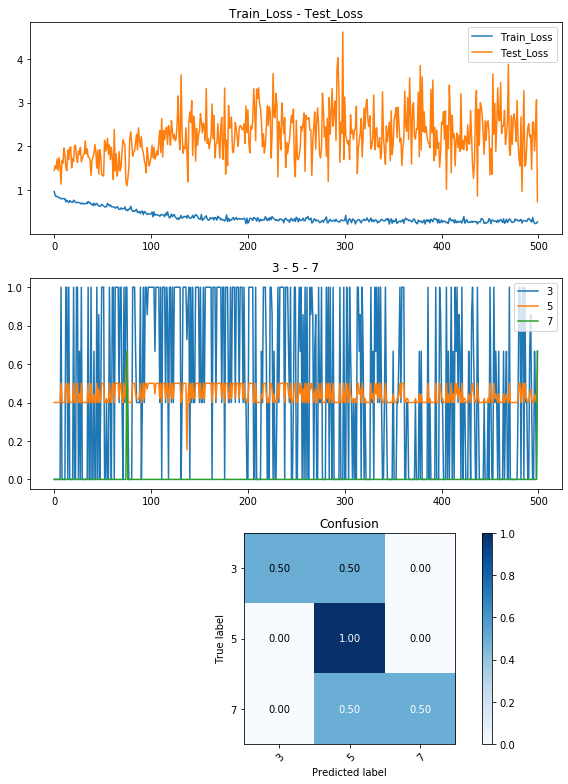

In [0]:
# track losses and f-scores
tb = TorchBoard("Train_Loss", "Test_Loss", *map(str, class_bins.keys()))
tb.add_stat(ConfusionMatrix(class_bins.keys(), name="Confusion", normalize=True))
# compute loss weights of each class by the number of examples associated
weight = torch.from_numpy(1 / np.sqrt(np.bincount(train_data[:][-1].flatten().numpy())))
weight = (weight / weight.sum()).float().to(device)

best_fscore, start = -1, time()
for epoch in range(epochs):

    # train model
    model.train()
    # reset for epoch
    start_epoch = time()
    running_loss = 0

    # train loop
    for i, (x, y_hat) in enumerate(train_dataloader):
        optim.zero_grad()

        # pass through model
        y = model.forward(x.to(device))
        # compute error
        loss = model.loss(y, y_hat.to(device))
        running_loss += loss.item()
        # update model parameters
        loss.backward()
        optim.step()
        # log
        print("\rEpoch {0}/{1}\t- Batch {2}/{3}\t- Average Loss {4:.02f}\t - Time {5:.04f}s"
            .format(epoch+1, epochs, i+1, len(train_dataloader), running_loss/(i+1), time() - start), end='', flush=True)

    # add to statistic
    tb.Train_Loss += running_loss / len(train_dataloader)

    # eval model
    model.eval()
    # initialize confusion matrix
    confusion_matrix = np.zeros((K, K))
    running_loss = 0

    for x, y_hat in test_dataloader:
        # pass through model and compute error
        y = model.forward(x.to(device))
        running_loss += model.loss(y, y_hat.to(device)).item()
        # update confusion matrix
        for actual, pred in zip(y_hat.flatten().cpu().numpy(), torch.argmax(y.reshape(-1, K), dim=-1).cpu().numpy()):
            confusion_matrix[actual, pred] += 1

    # update board
    tb.Confusion += confusion_matrix
    tb.Test_Loss += running_loss / len(test_dataloader)
    # compute f-scores from confusion matrix
    f_scores = compute_fscores(confusion_matrix)
    for c, f in zip(class_bins.keys(), f_scores):
        tb[str(c)] += f
    # save board
    fig = tb.create_fig([
            [("Train_Loss", "Test_Loss")], 
            [tuple(map(str, class_bins.keys()))], 
            [("Confusion", )]
        ], figsize=(8, 11)
    )
    fig.savefig(os.path.join(save_path, "board.pdf"), format="pdf")
    # save model and best board if fscores improved
    if sum(f_scores) > best_fscore:
        fig.savefig(os.path.join(save_path, "best_board.pdf"), format="pdf")
        model.save(save_path)
        best_fscore = sum(f_scores)
    # end epoch
    print()